In [1]:
import numpy as np
import os
from src.utils.distributions import Normal
from src.utils.mouselab_PAR import MouselabPar
from src.utils.experiment_creation import create_init, create_tree
import math
from matplotlib import pyplot as plt
from tqdm import tqdm
import pickle
import seaborn as sns
import copy
import json

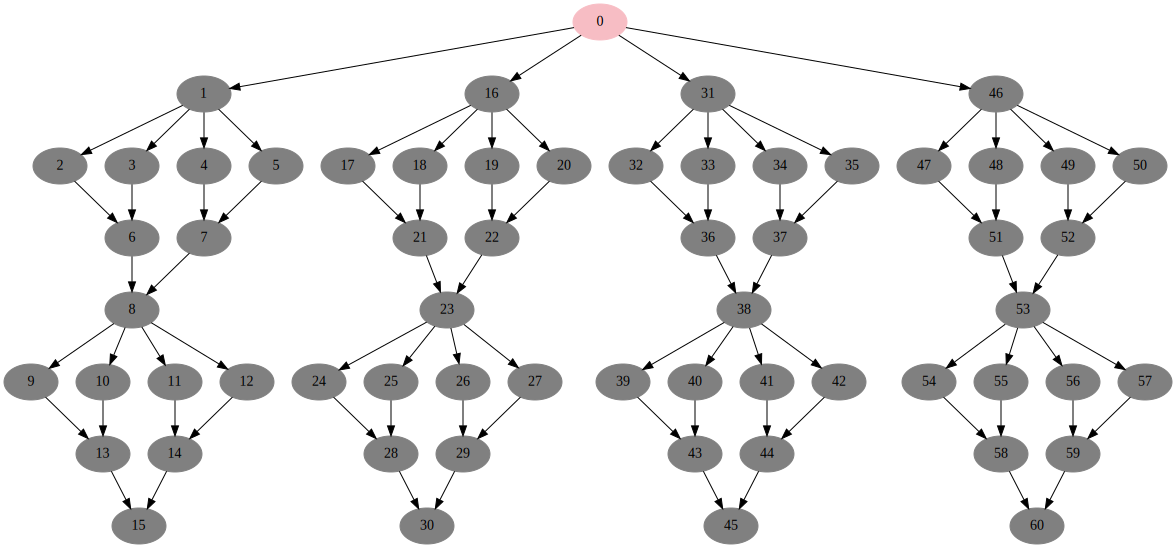

In [2]:
TREE = create_tree()
INIT = create_init()

MAX_ACTIONS = 200
env = MouselabPar(TREE, INIT, cost=0, tau=0, repeat_cost=0, myopic_mode="normal", term_belief=False)

env._render()

Tau mean: 0.004857, min: 0.0005, max: 0.0095
Cost mean: 0.0529, min: 0.01, max: 0.11


Text(0.5, 1.0, 'Cost')

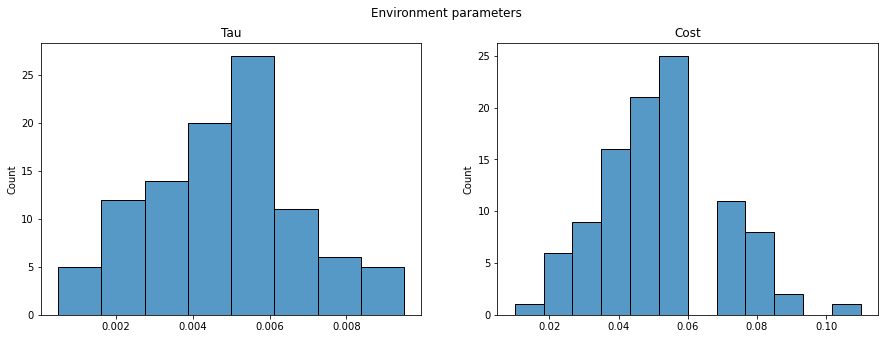

In [3]:
from scipy.stats import truncnorm

def get_truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

tau_gen = get_truncated_normal()
np.random.seed(0)

tau_mu, tau_sigma = 0.005, 0.002
cost_mu, cost_sigma = 0.05, 0.02
tau_gen = get_truncated_normal(mean=tau_mu, sd=tau_sigma, low=0.0001, upp=0.1)
cost_gen = get_truncated_normal(mean=cost_mu, sd=cost_sigma, low=0.01, upp=0.5)

TAUS = tau_gen.rvs(100).round(4)
COSTS = cost_gen.rvs(100).round(2)
#TAUS = np.random.normal(loc=tau_mu, scale=tau_sigma, size=500).round(4)
#COSTS = np.random.normal(loc=cost_mu, scale=cost_sigma, size=500).round(2)
print(f"Tau mean: {np.mean(TAUS)}, min: {np.min(TAUS)}, max: {np.max(TAUS)}")
print(f"Cost mean: {np.mean(COSTS)}, min: {np.min(COSTS)}, max: {np.max(COSTS)}")

fig, ax = plt.subplots(1, 2, figsize=(15, 5), sharey=False)
fig.suptitle('Environment parameters')
sns.histplot(ax=ax[0], data=TAUS)
ax[0].set_title("Tau")
sns.histplot(ax=ax[1], data=COSTS)
ax[1].set_title("Cost")

In [4]:
param_dict = {i: (COST, TAU) for i, (COST, TAU) in enumerate(zip(COSTS, TAUS))}

with open("./data/environments/params.json", mode="w") as f:
    json.dump(param_dict, f)

In [29]:
SEED = 0

for j, (COST, TAU) in tqdm(enumerate(zip(COSTS, TAUS))):

    iter_str = "0" + str(j) if j < 10 else str(j)

    env_data = {}
    env_data["parameter"] = {
        "tree": TREE,
        "init": INIT,
        "tau": TAU,
        "cost": COST,
        "seed": SEED,
        "max_actions": MAX_ACTIONS,
        "parameter_index": iter_str
    }

    env_data["envs"] = {}
    for i in range(25):
        np.random.seed(i+SEED)
        env = MouselabPar(TREE, INIT, cost=COST, tau=TAU, repeat_cost=COST, myopic_mode="normal", term_belief=False)
        env.ground_truth = np.round(env.ground_truth, 2)
        truth = env.ground_truth
        best_reward = np.round(env.ground_truth_reward(),2)
        available_actions = list(env.actions(env._state))
        samples = {}
        for action in available_actions:
            # Single tau
            if action is not env.term_action:
                action_dist = Normal(truth[action], 1/math.sqrt(TAU))
                action_samples = np.round(action_dist.sample(n=MAX_ACTIONS), 2).tolist()
                samples[action] = action_samples
        env_data["envs"][i] = {
            "ground_truth": truth,
            "samples": samples,
            "best_path_reward": best_reward
        }

    path = f"./res/po_main/4_60/{iter_str}_{str(COST)[2:]}_{str(TAU)[2:]}.p"

    # Uncomment to save env data
    with open(path, mode="wb") as f:
        pickle.dump(env_data, f)

100it [00:28,  3.54it/s]


In [7]:
# Myopic policy on precalculated samples
def run_myopic(truth_, samples_, parameter=None):
    if parameter is not None:
        TREE, INIT, TAU, COST = parameter["tree"], parameter["init"], parameter["tau"], parameter["cost"]
    env = MouselabPar(TREE, INIT, cost=COST, tau=TAU, repeat_cost=COST, myopic_mode="old", term_belief=False)
    # Deep copy 
    truth = copy.deepcopy(truth_)
    samples = copy.deepcopy(samples_)
    env.ground_truth = truth
    done = False
    i = 0
    rew = 0
    expected_term_reward = 0
    acts = []
    repeat_clicks = 0
    while not done:
        available_actions = list(env.actions(env._state))
        expected_reward = [sum(env.myopic_action_feature(a)) for a in available_actions]
        action = available_actions[np.argmax(expected_reward)]
        if action is not env.term_action:
            obs = samples[action].pop()
        else:
            obs = None
            expected_term_reward = env.expected_term_reward(env._state)
        state, reward, done, obs = env._step(action, obs=obs)
        rew += reward
        if action in acts:
            repeat_clicks += 1
        acts.append(action)
        i += 1
    return rew, acts, expected_term_reward, repeat_clicks

In [8]:
# All created files
path, _, filenames = next(os.walk("./res/po_main/4_60/"))
filepaths = [os.path.join(path, filename) for filename in filenames]

In [9]:
avg_reward = []
avg_clicks = []
avg_repeat_clicks = []

# Add myopic rewards to env data
for fp in tqdm(filepaths):
    with open(fp, mode="rb") as f:
        env_data = pickle.load(f)
    
    parameter = env_data["parameter"]
    myopic_rewards = []
    myopic_actions = []
    myopic_repeat_clicks = []
    myopic_expected_rewards = []
    for i in range(len(env_data["envs"])):
        truth = env_data["envs"][i]["ground_truth"]
        samples = env_data["envs"][i]["samples"]
        rew_mp, acts_mp, exp_rew_mp, repeat_clicks = run_myopic(truth, samples, parameter)
        env_data["envs"][i]["mp_reward"] = rew_mp
        env_data["envs"][i]["mp_actions"] = acts_mp
        env_data["envs"][i]["mp_exp_reward"] = exp_rew_mp
        env_data["envs"][i]["mp_repeat_clicks"] = repeat_clicks
        myopic_rewards.append(rew_mp)
        myopic_actions.append(acts_mp)
        myopic_repeat_clicks.append(repeat_clicks)
        myopic_expected_rewards.append(exp_rew_mp)
    avg_repeat_clicks.append(np.mean(myopic_repeat_clicks))
    avg_reward.append(np.mean(myopic_expected_rewards))
    avg_clicks.append(np.mean([len(x) for x in myopic_actions]))

    with open(fp, mode="wb") as f:
        pickle.dump(env_data, f)

100%|██████████| 100/100 [22:14<00:00, 13.34s/it]


100%|██████████| 100/100 [00:01<00:00, 59.49it/s]


18.006
4.8928


<AxesSubplot:ylabel='Count'>

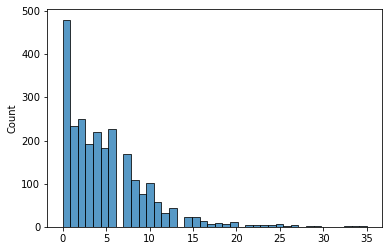

In [13]:
lengths = []
repeat_lengths = []
# Add myopic rewards to env data
for fp in tqdm(filepaths):
    with open(fp, mode="rb") as f:
        env_data = pickle.load(f)
        for i in range(len(env_data["envs"])):
            lengths.append(len(env_data["envs"][i]["mp_actions"]))
            repeats = 0
            for click_index, click in enumerate(env_data["envs"][i]["mp_actions"]):
                if click in env_data["envs"][i]["mp_actions"][:click_index]:
                    repeats += 1
            repeat_lengths.append(repeats)
print(np.mean(lengths))
print(np.mean(repeat_lengths))

In [12]:
print(np.mean(avg_clicks))
print(np.mean(avg_repeat_clicks))

18.006
4.892799999999999


Text(0.5, 1.0, 'Expected reward')

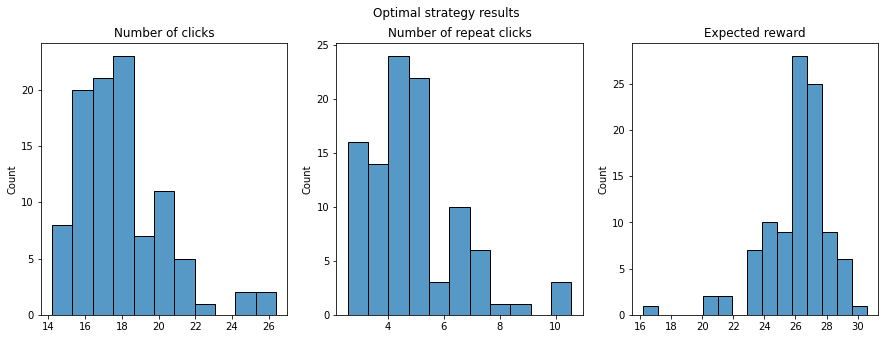

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharey=False)
fig.suptitle('Optimal strategy results')
sns.histplot(ax=ax[0], data=avg_clicks)
ax[0].set_title("Number of clicks")
sns.histplot(ax=ax[1], data=avg_repeat_clicks)
ax[1].set_title("Number of repeat clicks")
sns.histplot(ax=ax[2], data=avg_reward)
ax[2].set_title("Expected reward")


In [34]:
# Create env json files
for fp in filepaths:
    with open(fp, mode="rb") as f:
        env_data = pickle.load(f)

    # Create json
    trial_data = []
    for i in range(len(env_data["envs"])):
        env = env_data["envs"][i]
        trial = {
            "trial_id": i,
            "stateRewards": env["ground_truth"].tolist(),
            "samples": env["samples"],
            "expReward": env["mp_exp_reward"],
            "n_actions": env["mp_actions"]
        }
        trial_data.append(trial)

    TAU = env_data["parameter"]["tau"]
    COST = env_data["parameter"]["cost"]
    INDEX = env_data["parameter"]["parameter_index"]

    path = f"./res/po_main/4_60_json/{INDEX}_{str(COST)[2:]}_{str(TAU)[2:]}.json"
    with open(path, 'w') as outfile:
        json.dump(trial_data, outfile)

Cost: 0.25, 0.05
Precision: 0.001, 0.01

In [14]:
# Env Structure PO
def create_env_structure_po(env):
    def state_representation(state):
        """ State encoding: [[prob, value]]
        """
        if hasattr(state, "sample"):
            return [float(state.mu), float(state.sigma)]
        else: 
            return [float(state), 0]

    def vpi_action(action, env):
        paths = env.path_to(action)
        flat_paths = [int(node) for path in paths for node in path]
        obs = (*env.subtree[action], *flat_paths)
        obs = list(np.unique(obs))
        return obs
        
    state_init = {str(i):state_representation(state) for i, state in enumerate(env.init)}
    paths = list(env.paths)
    #vpi_subsets = {str(a):vpi_action(a, env) for a in range(1, len(TREE))}
    reward_groups = {reward:[] for reward in np.unique([x.sigma for x in env.init[1:]])}
    for i in range(1, len(env.init)):
        reward_groups[env.init[i].sigma].append(i)
    # Cost and tau depend on condition and will be passed from the json containing the samples
    env_structure = {
        "init": state_init,
        "paths": paths,
        #"vpi_sets": vpi_subsets,
        "term_action": int(env.term_action),
        "reward_groups": list(reward_groups.values())
    }

    return env_structure

In [15]:
data = create_env_structure_po(env)

with open('./res/po_structure.json', 'w') as outfile:
    json.dump(data, outfile)